# Sampled CRF Basics Test

Yao Fu. University of Edinburgh<br />
yao.fu@ed.ac.uk<br />
May 2021

In [1]:
import torch
import matplotlib

import numpy as np
import pandas as pd 
import seaborn as sns
import torch.nn.functional as F

from tqdm import tqdm 
from torch import nn
from time import time
from frtorch import LinearChainCRF
from torch.optim import Adam

from frtorch import torch_model_utils as tmu
from matplotlib import pyplot as plt 

In [2]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

# Function and Class Definitions

In [3]:
# from https://github.com/mwaskom/seaborn/issues/2280

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

In [8]:
class CRFModel(nn.Module):
    def __init__(self, 
                 transition_scale, 
                 emission_scale, 
                 transition_bias, 
                 emission_bias, 
                 state_size, 
                 num_state, 
                 max_len,
                 tau
                ):
        super().__init__()
        self.crf = LinearChainCRF()
        self.transition_bias = transition_bias
        self.emission_bias = emission_bias
        self.num_state = num_state
        self.transition_scale = transition_scale
        self.state_matrix = nn.Parameter(torch.normal(
            size=[num_state, state_size], mean=0.0, std=transition_scale))
        self.emission_scale = emission_scale
        self.emission_weight = nn.Parameter(torch.normal(
            size=[2, max_len, state_size], mean=0.0, std=emission_scale))
        self.lens = torch.tensor([max_len, max_len])
        self.tau = tau
        return 
    
    def emb_norm(self):
        state_matrix = self.state_matrix / torch.sqrt((self.state_matrix ** 2).sum(-1, keepdim=True))
        emission_weight = self.emission_weight / torch.sqrt((self.emission_weight ** 2).sum(-1, keepdim=True))
        
        transition = torch.matmul(state_matrix, state_matrix.transpose(1, 0))
#         transition = transition + self.transition_bias
        
        emission = torch.matmul(emission_weight, state_matrix.transpose(1, 0))
#         emission = emission + self.emission_bias
        return state_matrix, emission_weight, transition, emission
    
    def forward_sum(self, transition=None, emission=None):
        state_matrix, emission_weight, transition, emission = self.emb_norm()
        _, log_Z = self.crf.forward_sum(transition, emission, self.lens)
        return log_Z
    
    def topK_sum(self, num_sum):
        state_matrix, emission_weight, transition, emission = self.emb_norm()
        log_Z_ksum = self.crf.forward_topk(state_matrix, emission, self.lens, num_sum)
        return log_Z_ksum
    
    def forward_approx(self, num_sum, proposal='softmax', transition_proposal='none'):
        state_matrix, emission_weight, transition, emission = self.emb_norm()
        log_Z_est = self.crf.forward_approx(state_matrix, emission, self.lens, num_sum, proposal, transition_proposal)
        return log_Z_est
    
    def check_potential(self):
        with torch.no_grad():
            state_matrix, emission_weight, transition, emission = self.emb_norm()
            
            print('transition gap:', transition.max() - transition.mean())
            print('transition mean:', transition.mean())
            print('abs transition mean:', transition.abs().mean())
            print('emission gap:', emission.max() - emission.mean())
            print('emission mean:', emission.mean())
            print('abs emission mean:', emission.abs().mean())
            
            print('max emission prob:', F.softmax(emission / self.tau, -1).max(-1).values.mean())
            
            log_Z = self.forward_sum()
            print('log Z exact:', log_Z)
            
            log_Z_ = self.forward_sum(transition=0 * transition)
            print('if change to 0 transition, then log Z:', log_Z_)
            
            log_Z_ = self.forward_sum(emission=0 * emission)
            print('if change to 0 emission, then log Z:', log_Z_)

            log_Z_ = self.forward_sum(transition=0 * transition, emission=0 * emission)
            print('if change to all 0, then log Z:', log_Z_)
            
            log_Z_est = self.forward_approx(1)
            print('log Z single estimate:', log_Z_est)

            log_Z_est = self.forward_approx(self.num_state - 1)
            print('log Z full estimate:', log_Z_est)
        return 
    
    def simulate(self, N=100, num_sum=1, proposal='softmax', transition_proposal='none'):
        with torch.no_grad():
            estimates = []
            start_time = time()
            for i in range(N):
                if(i % 10 == 0): print('.', end=' ')
                estimates.append(self.forward_approx(num_sum, proposal, transition_proposal))
            print()
            estimates = torch.stack(estimates, dim=1)
            est_mean = estimates.mean(dim=-1)
            print('log Z large scale etimate, mean:', est_mean, 'std:', estimates.std(-1))
            print('approximate time %.2f s' % ((time() - start_time) / N))
        return estimates, est_mean
    
    def simulate_entropy(self, N=100, num_sum=1, proposal='softmax', transition_proposal='none'):
        with torch.no_grad():
            estimates = []
            start_time = time()
            for i in range(N):
                if(i % 10 == 0): print('.', end=' ')
                estimates.append(self.entropy_approx(num_sum))
            print()
            estimates = torch.stack(estimates, dim=1)
            est_mean = estimates.mean(dim=-1)
            print('Entropy large scale etimate, mean:', est_mean, 'std:', estimates.std(-1))
            print('approximate time %.2f s' % ((time() - start_time) / N))
        return estimates, est_mean
    
    def entropy_approx(self, num_sum):
        state_matrix, emission_weight, transition, emission = self.emb_norm()
        H = self.crf.entropy_approx(state_matrix, emission, self.lens, num_sum)
        return H
    
    def entropy(self):
        state_matrix, emission_weight, transition, emission = self.emb_norm()
        H = self.crf.entropy(transition, emission, self.lens)
        return H
    
#     def entropy(self, tau=None):
#         if(tau is None): tau = self.tau
#         state_matrix, emission_weight, transition, emission = self.emb_norm()

#         prior = F.softmax(transition / tau, -1)
#         prior = prior.mean(0)

#         stepwise = F.softmax(emission / tau, -1)
#         entropy = -(stepwise * (stepwise + 1e-8).log()).sum(-1).mean()
#         return entropy

# Biasedness and Variance

## Uniform Case

### Compare Memory Budget

In [5]:
transition_scale = 0.1
emission_scale = 0.1
transition_bias = -3
emission_bias = -3
# transition_bias = 0
# emission_bias = 0
state_size = 762
num_state= 1000
max_len = 100
tau = 0.1

crfm = CRFModel(transition_scale, 
                emission_scale, transition_bias, emission_bias, state_size, num_state, max_len, tau)
log_Z = crfm.forward_sum()
print(log_Z)
crfm.check_potential()

tensor([691.0945, 691.1144], grad_fn=<LogsumexpBackward>)
transition gap: tensor(0.9989)
transition mean: tensor(0.0011)
abs transition mean: tensor(0.0299)
emission gap: tensor(0.1480)
emission mean: tensor(0.0002)
abs emission mean: tensor(0.0289)
max emission prob: tensor(0.0030)
log Z exact: tensor([691.0945, 691.1144])
if change to 0 transition, then log Z: tensor([691.0945, 691.1144])
if change to 0 emission, then log Z: tensor([691.0945, 691.1144])
if change to all 0, then log Z: tensor([691.0945, 691.1144])
log Z single estimate: tensor([691.6420, 690.7291])
log Z full estimate: tensor([691.0945, 691.1144])


In [7]:
estimates_1, est_mean = crfm.simulate(num_sum=1)
estimates_100, est_mean = crfm.simulate(num_sum=100)
estimates_100_trans, est_mean = crfm.simulate(num_sum=100, transition_proposal='abs_sum')
estimates_500, est_mean = crfm.simulate(num_sum=200)
estimates_500_trans, est_mean = crfm.simulate(num_sum=200, transition_proposal='abs_sum')

. . . . . . . . . . 
log Z large scale etimate, mean: tensor([690.9655, 690.9441]) std: tensor([0.5283, 0.5000])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([691.0158, 691.0511]) std: tensor([0.3574, 0.3870])
approximate time 0.14 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([690.9430, 691.0532]) std: tensor([0.2555, 0.4120])
approximate time 0.13 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([690.9947, 691.0704]) std: tensor([0.3234, 0.3426])
approximate time 0.29 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([691.0356, 691.0580]) std: tensor([0.2956, 0.3444])
approximate time 0.30 s


In [8]:
log_Z = crfm.forward_sum()
print(log_Z)

tensor([691.0945, 691.1144], grad_fn=<LogsumexpBackward>)


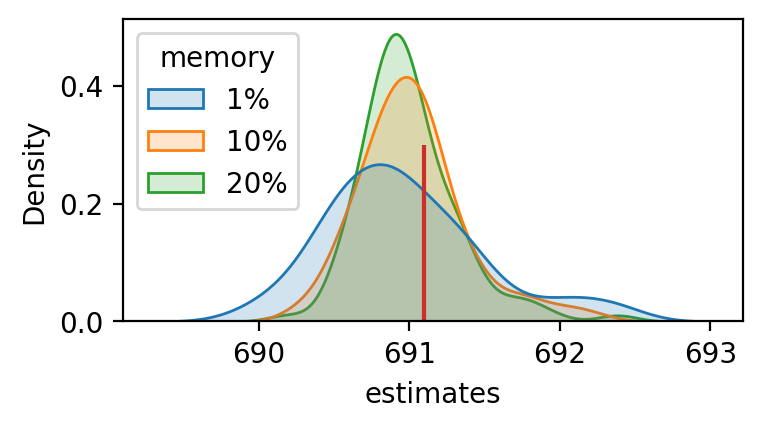

In [9]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
                           + list(estimates_500[0]) 
                          ), 
     'memory': np.array(
                          ['1%'] * 100
                          + ['10%'] * 100
                          + ['20%'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.3
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

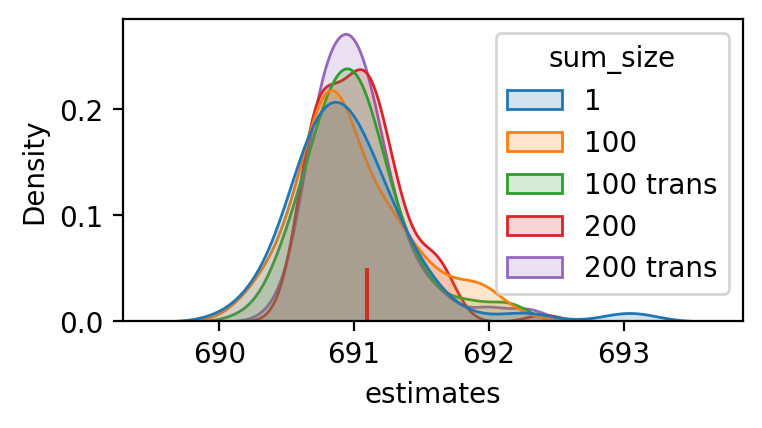

In [17]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
                           + list(estimates_100_trans[0]) 
                           + list(estimates_500[0]) 
                           + list(estimates_500_trans[0])
                          ), 
     'sum_size': np.array(
                          ['1'] * 100
                          + ['100'] * 100
                          + ['100 trans'] * 100
                          + ['200'] * 100
                          + ['200 trans'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='sum_size', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper right')

### Compare Ksum

In [11]:
with torch.no_grad():
    log_Z_Ksum_500 = crfm.topK_sum(500)
    print(log_Z_Ksum_500)
    log_Z_Ksum_800 = crfm.topK_sum(800)
    print(log_Z_Ksum_800)
    log_Z_Ksum_900 = crfm.topK_sum(900)
    print(log_Z_Ksum_900)
#     log_Z_Ksum_900 = crfm.topK_sum(1000)
#     print(log_Z_Ksum_900)

tensor([624.6302, 624.6413])
tensor([670.0265, 670.0393])
tensor([681.2482, 681.2651])


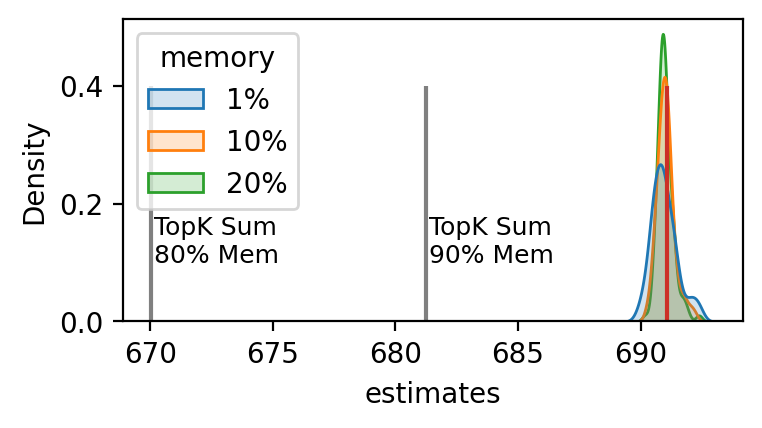

In [12]:
plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.4
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
p2 = plt.vlines([float(log_Z_Ksum_800[0]), float(log_Z_Ksum_900[0])], ymin=0, ymax=ymax, color='gray', label='topK')
plt.text(log_Z_Ksum_800[0]+0.1, 0.1, 'TopK Sum\n80% Mem', size=9)
plt.text(log_Z_Ksum_900[0]+0.1, 0.1, 'TopK Sum\n90% Mem', size=9)

move_legend(ax, 'upper left')

### Compare proposal

In [98]:
crfm.entropy()

tensor(6.8424, grad_fn=<NegBackward>)

In [99]:
estimates_1, est_mean = crfm.simulate(num_sum=1)
estimates_1_trans, est_mean = crfm.simulate(num_sum=1, transition_proposal='abs_sum')
estimates_unifrom, est_mean = crfm.simulate(num_sum=1, proposal='uniform')
estimates_unifrom_trans, est_mean = crfm.simulate(num_sum=1, proposal='uniform', transition_proposal='abs_sum')

estimates_200, est_mean = crfm.simulate(num_sum=200)
estimates_200_trans, est_mean = crfm.simulate(num_sum=200, transition_proposal='abs_sum')
estimates_unifrom_200, est_mean = crfm.simulate(num_sum=200, proposal='uniform')
estimates_unifrom_200_trans, est_mean = crfm.simulate(num_sum=200, proposal='uniform', transition_proposal='abs_sum')

log_Z = crfm.forward_sum()
print(log_Z)

. . . . . . . . . . 
log Z large scale etimate, mean: tensor([93.9738, 93.9118]) std: tensor([0.5106, 0.4899])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([93.5435, 93.3812]) std: tensor([1.4142, 1.1676])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([93.8302, 93.8742]) std: tensor([0.6111, 0.6040])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([93.9118, 93.8459]) std: tensor([0.6113, 0.5604])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([94.0403, 94.0788]) std: tensor([0.2999, 0.3071])
approximate time 0.38 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([93.9212, 93.6868]) std: tensor([0.6986, 0.6414])
approximate time 0.39 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([94.0360, 93.9995]) std: tensor([0.4201, 0.3630])
approximate time 0.36 s
. . . . . . . . . . 
log Z large scale etimate, mean: t

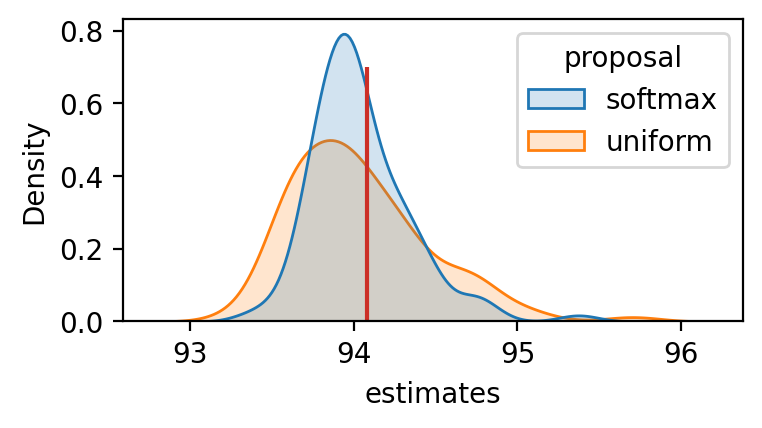

In [104]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_200[0]) 
#                            + list(estimates_1_trans[0]) 
                           + list(estimates_unifrom_200[0]) 
#                            + list(estimates_unifrom_trans[0]) 
                          ), 
     'proposal': np.array(
                          ['softmax'] * 100
#                           + ['softmax + prior'] * 100
                          + ['uniform'] * 100
#                           + ['uniform + prior'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.7
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper right')

## Small level entropy

### Compare Memory Budget

In [38]:
transition_scale = 0.1
emission_scale = 0.1
transition_bias = 0
emission_bias = 0
# transition_bias = -3
# emission_bias = -3
state_size = 762
num_state= 1000
max_len = 100
tau = 0.1

crfm = CRFModel(transition_scale, 
                emission_scale, transition_bias, emission_bias, state_size, num_state, max_len, tau)
log_Z = crfm.forward_sum()
print(log_Z)
crfm.check_potential()

tensor([691.0581, 691.0742], grad_fn=<LogsumexpBackward>)
transition gap: tensor(0.9991)
transition mean: tensor(0.0009)
abs transition mean: tensor(0.0299)
emission gap: tensor(0.1591)
emission mean: tensor(-3.0722e-06)
abs emission mean: tensor(0.0290)
max emission prob: tensor(0.0031)
log Z exact: tensor([691.0581, 691.0742])
if change to 0 transition, then log Z: tensor([691.0581, 691.0742])
if change to 0 emission, then log Z: tensor([691.0581, 691.0742])
if change to all 0, then log Z: tensor([691.0581, 691.0742])
log Z single estimate: tensor([691.0588, 690.7701])
log Z full estimate: tensor([691.0581, 691.0742])


In [39]:
opt = Adam(crfm.parameters(), 1e-2, weight_decay=0.)
# opt = Adam(crfm.parameters(), 1e-2, weight_decay=1e-5)

In [40]:
ent = crfm.entropy()
print('initial entropy', ent)
max_steps = 100
for i in range(max_steps):
    crfm.zero_grad()
    ent = crfm.entropy()
    ent.backward()
    opt.step()
    if(i % 10 == 0):
        tmu.print_grad(crfm)
print('end entropy', ent)
print()
crfm.check_potential()

initial entropy tensor(6.8418, grad_fn=<NegBackward>)
gradient of the model parameters:
state_matrix 0.0033443032 1.4682781e-11
emission_weight 0.0033347625 7.297253e-11

gradient of the model parameters:
state_matrix 0.12985556 2.2166777e-08
emission_weight 0.13049342 1.11741166e-07

gradient of the model parameters:
state_matrix 0.02777569 1.0136972e-09
emission_weight 0.02541969 4.2396264e-09

gradient of the model parameters:
state_matrix 0.012862281 2.1740354e-10
emission_weight 0.011726126 9.0227276e-10

gradient of the model parameters:
state_matrix 0.0066195303 5.7580416e-11
emission_weight 0.0064705927 2.7472824e-10

gradient of the model parameters:
state_matrix 0.0040790667 2.186247e-11
emission_weight 0.0040159575 1.0582518e-10

gradient of the model parameters:
state_matrix 0.002647887 9.211168e-12
emission_weight 0.0024410589 3.9101673e-11

gradient of the model parameters:
state_matrix 0.0017838913 4.1803176e-12
emission_weight 0.0016097915 1.7005125e-11

gradient of the

In [41]:
estimates_1, est_mean = crfm.simulate(num_sum=1)
estimates_100, est_mean = crfm.simulate(num_sum=100)
estimates_100_trans, est_mean = crfm.simulate(num_sum=100, transition_proposal='abs_sum')
estimates_500, est_mean = crfm.simulate(num_sum=200)
estimates_500_trans, est_mean = crfm.simulate(num_sum=200, transition_proposal='abs_sum')
log_Z = crfm.forward_sum()
print(log_Z)

. . . . . . . . . . 
log Z large scale etimate, mean: tensor([714.8182, 715.3398]) std: tensor([6.3128, 4.9330])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([722.3445, 722.2733]) std: tensor([4.8287, 4.8617])
approximate time 0.17 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([723.4751, 724.2366]) std: tensor([4.4007, 4.1606])
approximate time 0.18 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([730.2101, 730.3781]) std: tensor([1.6082, 1.6686])
approximate time 0.40 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([725.0605, 725.3211]) std: tensor([3.5584, 3.6714])
approximate time 0.39 s
tensor([731.4861, 731.4946], grad_fn=<LogsumexpBackward>)


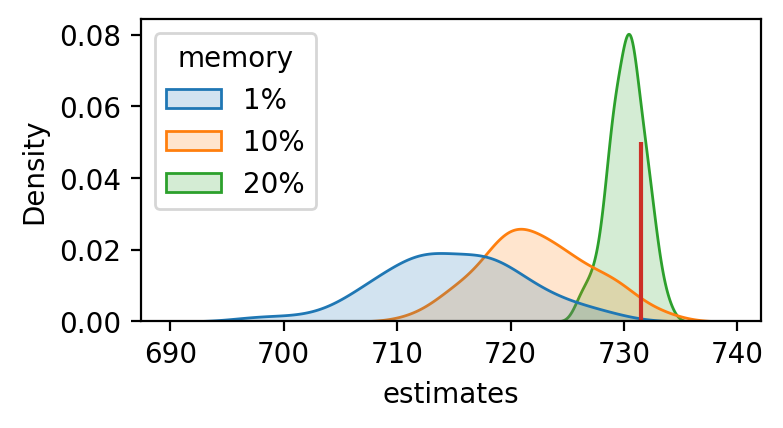

In [42]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
#                            + list(estimates_100_trans[0]) 
                           + list(estimates_500[0]) 
#                            + list(estimates_500_trans[0])
                          ), 
     'memory': np.array(
                          ['1%'] * 100
                          + ['10%'] * 100
#                           + ['100 trans'] * 100
                          + ['20%'] * 100
#                           + ['200 trans'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,)
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

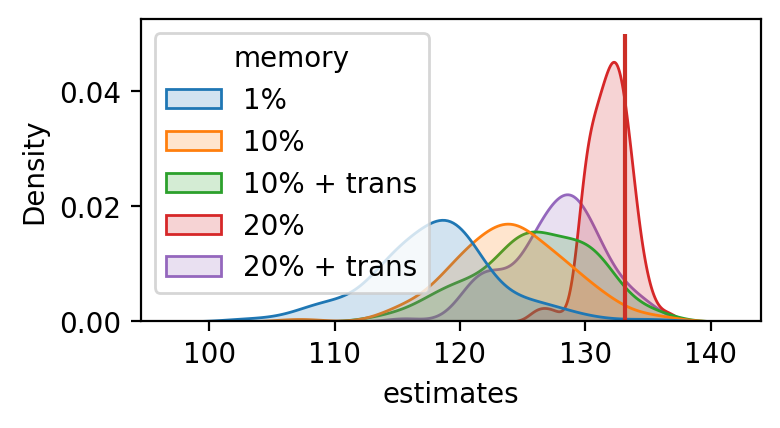

In [47]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
                           + list(estimates_100_trans[0]) 
                           + list(estimates_500[0]) 
                           + list(estimates_500_trans[0])
                          ), 
     'memory': np.array(
                          ['1%'] * 100
                          + ['10%'] * 100
                          + ['10% + trans'] * 100
                          + ['20%'] * 100
                          + ['20% + trans'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,)
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

### Compare Ksum

In [43]:
with torch.no_grad():
    log_Z_Ksum_500 = crfm.topK_sum(500)
    print(log_Z_Ksum_500)
    log_Z_Ksum_800 = crfm.topK_sum(800)
    print(log_Z_Ksum_800)
    log_Z_Ksum_900 = crfm.topK_sum(900)
    print(log_Z_Ksum_800)

tensor([637.1627, 637.1630])
tensor([702.3290, 702.3120])
tensor([702.3290, 702.3120])


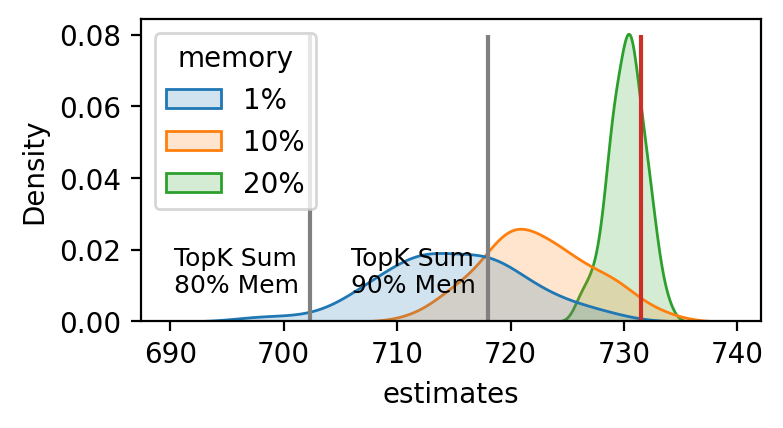

In [47]:
plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.08
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
p2 = plt.vlines([float(log_Z_Ksum_800[0]), float(log_Z_Ksum_900[0])], ymin=0, ymax=ymax, color='gray', label='topK')
plt.text(log_Z_Ksum_800[0] - 12, 0.1 * ymax, 'TopK Sum\n80% Mem', size=9)
plt.text(log_Z_Ksum_900[0] - 12, 0.1 * ymax, 'TopK Sum\n90% Mem', size=9)

move_legend(ax, 'upper left')

### Compare proposal

In [81]:
crfm.entropy()

tensor(0.1956, grad_fn=<NegBackward>)

In [88]:
estimates_1, est_mean = crfm.simulate(num_sum=1)
estimates_1_trans, est_mean = crfm.simulate(num_sum=1, transition_proposal='abs_sum')
estimates_unifrom, est_mean = crfm.simulate(num_sum=1, proposal='uniform')
estimates_unifrom_trans, est_mean = crfm.simulate(num_sum=1, proposal='uniform', transition_proposal='abs_sum')

estimates_200, est_mean = crfm.simulate(num_sum=200)
estimates_200_trans, est_mean = crfm.simulate(num_sum=200, transition_proposal='abs_sum')
estimates_unifrom_200, est_mean = crfm.simulate(num_sum=200, proposal='uniform')
estimates_unifrom_200_trans, est_mean = crfm.simulate(num_sum=200, proposal='uniform', transition_proposal='abs_sum')

log_Z = crfm.forward_sum()
print(log_Z)

. . . . . . . . . . 
log Z large scale etimate, mean: tensor([118.4575, 117.4321]) std: tensor([5.7861, 5.5010])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([122.6050, 121.8991]) std: tensor([4.5946, 5.0370])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([123.4580, 122.9679]) std: tensor([4.3448, 4.5283])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([123.3902, 123.9053]) std: tensor([4.6348, 4.7504])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([131.7441, 132.0553]) std: tensor([1.7789, 1.5163])
approximate time 0.36 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([127.2654, 127.2761]) std: tensor([4.0302, 3.5834])
approximate time 0.38 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([132.5439, 132.3373]) std: tensor([1.4200, 1.4378])
approximate time 0.36 s
. . . . . . . . . . 
log Z large scale et

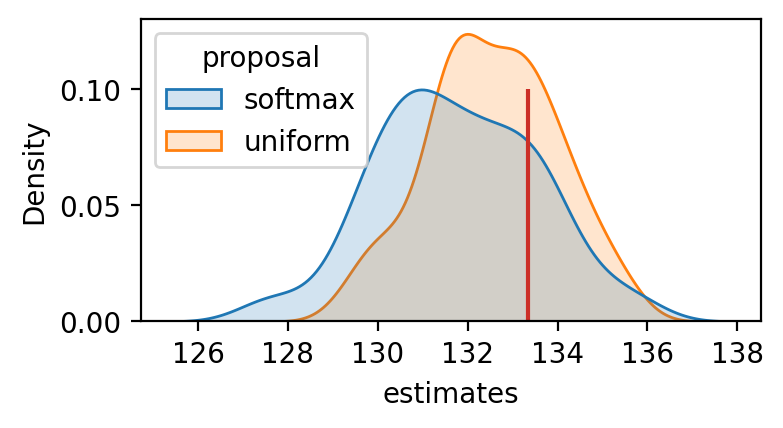

In [91]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_200[0]) 
                           + list(estimates_unifrom_200[0]) 
                          ), 
     'proposal': np.array(
                          ['softmax'] * 100
                          + ['uniform'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.1
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

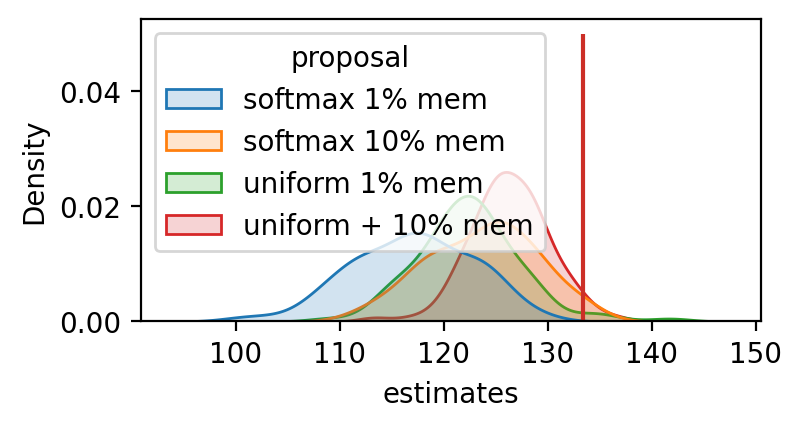

In [86]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
                           + list(estimates_unifrom[0]) 
                           + list(estimates_unifrom_100[0]) 
                          ),
     'proposal': np.array(
                          ['softmax 1% mem'] * 100
                          + ['softmax 10% mem'] * 100
                          + ['uniform 1% mem'] * 100
                          + ['uniform + 10% mem'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

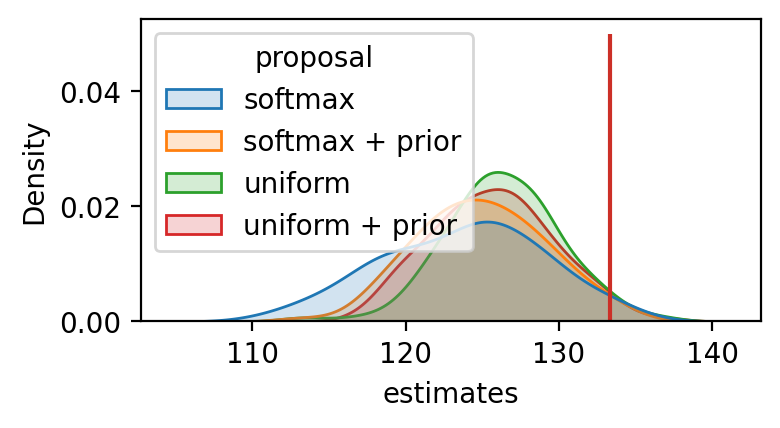

In [87]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_100[0]) 
                           + list(estimates_100_trans[0]) 
                           + list(estimates_unifrom_100[0]) 
                           + list(estimates_unifrom_100_trans[0]) 
                          ), 
     'proposal': np.array(
                          ['softmax'] * 100
                          + ['softmax + prior'] * 100
                          + ['uniform'] * 100
                          + ['uniform + prior'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

## Middle level entropy

### Compare Memory Budget

In [28]:
transition_scale = 0.1
emission_scale = 0.1
# transition_bias = -1
# emission_bias = -1
# transition_bias = -3
# emission_bias = -3
transition_bias = 0
emission_bias = 0
state_size = 762
num_state= 1000
max_len = 100
tau = 0.1

crfm = CRFModel(transition_scale, 
                emission_scale, transition_bias, emission_bias, state_size, num_state, max_len, tau)
log_Z = crfm.forward_sum()
print(log_Z)
crfm.check_potential()

opt = Adam(crfm.parameters(), 1e-2, weight_decay=0.)

ent = crfm.entropy()
print('initial entropy', ent)
max_steps = 30
for i in range(max_steps):
    crfm.zero_grad()
    ent = crfm.entropy()
    ent.backward()
    opt.step()
    if(i % 10 == 0):
        tmu.print_grad(crfm)
print('end entropy', ent)
print()
crfm.check_potential()

tensor([691.0731, 691.0781], grad_fn=<LogsumexpBackward>)
transition gap: tensor(0.9990)
transition mean: tensor(0.0010)
abs transition mean: tensor(0.0299)
emission gap: tensor(0.1730)
emission mean: tensor(-3.0336e-05)
abs emission mean: tensor(0.0289)
max emission prob: tensor(0.0030)
log Z exact: tensor([691.0731, 691.0781])
if change to 0 transition, then log Z: tensor([691.0731, 691.0781])
if change to 0 emission, then log Z: tensor([691.0731, 691.0781])
if change to all 0, then log Z: tensor([691.0731, 691.0781])
log Z single estimate: tensor([690.3277, 690.7090])
log Z full estimate: tensor([691.0731, 691.0781])
initial entropy tensor(6.8420, grad_fn=<NegBackward>)
gradient of the model parameters:
state_matrix 0.0033296181 1.4554141e-11
emission_weight 0.0033437433 7.336646e-11

gradient of the model parameters:
state_matrix 0.13029388 2.231546e-08
emission_weight 0.1297692 1.1050402e-07

gradient of the model parameters:
state_matrix 0.028772801 1.0877698e-09
emission_weight 

In [29]:
estimates_1, est_mean = crfm.simulate(num_sum=1)
estimates_100, est_mean = crfm.simulate(num_sum=100)
estimates_100_trans, est_mean = crfm.simulate(num_sum=100, transition_proposal='abs_sum')
estimates_500, est_mean = crfm.simulate(num_sum=200)
estimates_500_trans, est_mean = crfm.simulate(num_sum=200, transition_proposal='abs_sum')
log_Z = crfm.forward_sum()
print(log_Z)

. . . . . . . . . . 
log Z large scale etimate, mean: tensor([696.0570, 695.9550]) std: tensor([2.6156, 2.9749])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([697.4995, 697.5915]) std: tensor([2.3035, 2.2640])
approximate time 0.16 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([695.9592, 695.1398]) std: tensor([3.0335, 3.1734])
approximate time 0.17 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([698.7445, 698.9169]) std: tensor([1.6098, 2.0297])
approximate time 0.35 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([699.1892, 699.3574]) std: tensor([1.6549, 1.6470])
approximate time 0.33 s
tensor([700.3523, 700.3365], grad_fn=<LogsumexpBackward>)


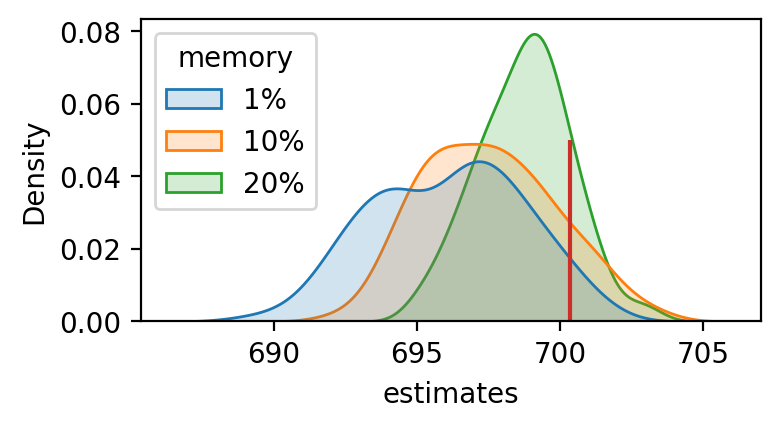

In [35]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
#                            + list(estimates_100_trans[0]) 
                           + list(estimates_500[0]) 
#                            + list(estimates_500_trans[0])
                          ), 
     'memory': np.array(
                          ['1%'] * 100
                          + ['10%'] * 100
#                           + ['100 trans'] * 100
                          + ['20%'] * 100
#                           + ['200 trans'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

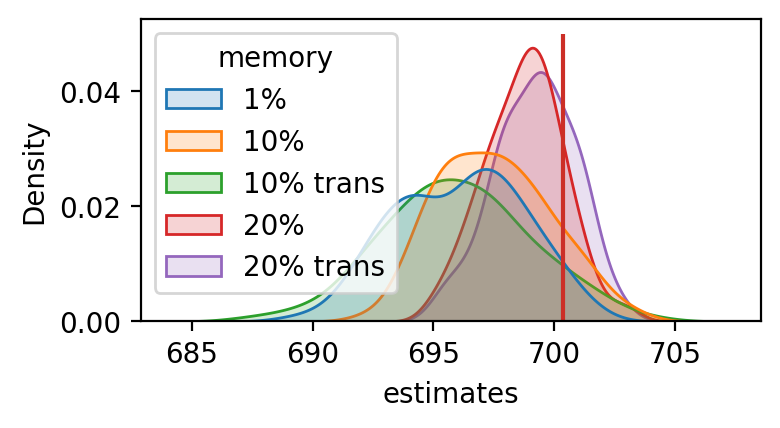

In [32]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_1[0]) 
                           + list(estimates_100[0]) 
                           + list(estimates_100_trans[0]) 
                           + list(estimates_500[0]) 
                           + list(estimates_500_trans[0])
                          ), 
     'memory': np.array(
                          ['1%'] * 100
                          + ['10%'] * 100
                          + ['10% trans'] * 100
                          + ['20%'] * 100
                          + ['20% trans'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.05
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

### Compare Ksum

In [33]:
with torch.no_grad():
    log_Z_Ksum_500 = crfm.topK_sum(500)
    print(log_Z_Ksum_500)
    log_Z_Ksum_800 = crfm.topK_sum(800)
    print(log_Z_Ksum_800)
    log_Z_Ksum_900 = crfm.topK_sum(900)
    print(log_Z_Ksum_800)

tensor([621.9494, 621.9296])
tensor([673.5426, 673.5473])
tensor([673.5426, 673.5473])


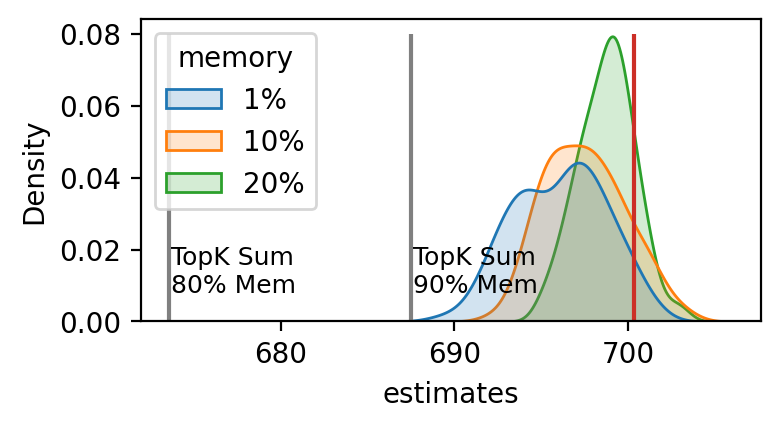

In [37]:
plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.08
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
p2 = plt.vlines([float(log_Z_Ksum_800[0]), float(log_Z_Ksum_900[0])], ymin=0, ymax=ymax, color='gray', label='topK')
plt.text(log_Z_Ksum_800[0]+0.1, 0.1 * ymax, 'TopK Sum\n80% Mem', size=9)
plt.text(log_Z_Ksum_900[0]+0.1, 0.1 * ymax, 'TopK Sum\n90% Mem', size=9)

move_legend(ax, 'upper left')

### Compare proposal

In [93]:
crfm.entropy()

tensor(0.3810, grad_fn=<NegBackward>)

In [94]:
estimates_1, est_mean = crfm.simulate(num_sum=1)
estimates_1_trans, est_mean = crfm.simulate(num_sum=1, transition_proposal='abs_sum')
estimates_unifrom, est_mean = crfm.simulate(num_sum=1, proposal='uniform')
estimates_unifrom_trans, est_mean = crfm.simulate(num_sum=1, proposal='uniform', transition_proposal='abs_sum')

estimates_200, est_mean = crfm.simulate(num_sum=200)
estimates_200_trans, est_mean = crfm.simulate(num_sum=200, transition_proposal='abs_sum')
estimates_unifrom_200, est_mean = crfm.simulate(num_sum=200, proposal='uniform')
estimates_unifrom_200_trans, est_mean = crfm.simulate(num_sum=200, proposal='uniform', transition_proposal='abs_sum')

log_Z = crfm.forward_sum()
print(log_Z)

. . . . . . . . . . 
log Z large scale etimate, mean: tensor([98.9290, 98.8914]) std: tensor([2.5504, 2.9681])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([94.1709, 94.7120]) std: tensor([4.4732, 4.6766])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([101.0319, 101.2107]) std: tensor([2.3452, 2.3388])
approximate time 0.03 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([101.2540, 100.9630]) std: tensor([2.1077, 2.1845])
approximate time 0.02 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([101.9188, 102.0205]) std: tensor([1.8665, 1.7911])
approximate time 0.38 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([102.6840, 102.8014]) std: tensor([1.4515, 1.2993])
approximate time 0.38 s
. . . . . . . . . . 
log Z large scale etimate, mean: tensor([102.3745, 102.8732]) std: tensor([1.5028, 1.5251])
approximate time 0.38 s
. . . . . . . . . . 
log Z large scale etimat

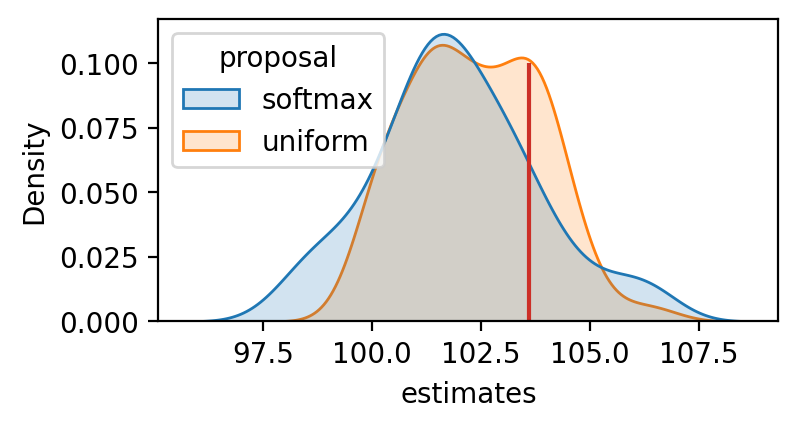

In [96]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(
                           list(estimates_200[0]) 
                           + list(estimates_unifrom_200[0]) 
                          ), 
     'proposal': np.array(
                          ['softmax'] * 100
                          + ['uniform'] * 100
                         )}
    )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2,
#                 legend=False
               )
ymax = 0.1
plt.vlines(float(log_Z[0]), ymin=0, ymax=ymax, color='#CC2F27')
move_legend(ax, 'upper left')

# Entropy

In [9]:
transition_scale = 0.1
emission_scale = 0.1
transition_bias = -3
emission_bias = -3
# transition_bias = 0
# emission_bias = 0
state_size = 762
num_state= 1000
max_len = 100
tau = 0.1

crfm = CRFModel(transition_scale, 
                emission_scale, transition_bias, emission_bias, state_size, num_state, max_len, tau)
log_Z = crfm.forward_sum()
print(log_Z)
crfm.check_potential()

tensor([691.0739, 691.0776], grad_fn=<LogsumexpBackward>)
transition gap: tensor(0.9990)
transition mean: tensor(0.0010)
abs transition mean: tensor(0.0299)
emission gap: tensor(0.1606)
emission mean: tensor(4.2571e-05)
abs emission mean: tensor(0.0289)
max emission prob: tensor(0.0030)
log Z exact: tensor([691.0739, 691.0776])
if change to 0 transition, then log Z: tensor([691.0739, 691.0776])
if change to 0 emission, then log Z: tensor([691.0739, 691.0776])
if change to all 0, then log Z: tensor([691.0739, 691.0776])
log Z single estimate: tensor([691.0408, 691.1236])
log Z full estimate: tensor([691.0739, 691.0776])


In [10]:
ent = crfm.entropy()
print(ent)

tensor([690.5489, 690.5500], grad_fn=<SumBackward1>)


In [12]:
estimates_1, est_mean = crfm.simulate_entropy(num_sum=1)
estimates_100, est_mean = crfm.simulate_entropy(num_sum=100)
estimates_200, est_mean = crfm.simulate_entropy(num_sum=200)
estimates_500, est_mean = crfm.simulate_entropy(num_sum=500)
estimates_1000, est_mean = crfm.simulate_entropy(num_sum=999)

. . . . . . . . . . 
Entropy large scale etimate, mean: tensor([0.8791, 0.8766]) std: tensor([0.0091, 0.0084])
approximate time 0.03 s
. . . . . . . . . . 
Entropy large scale etimate, mean: tensor([83.1297, 83.1754]) std: tensor([0.4501, 0.5152])
approximate time 0.15 s
. . . . . . . . . . 
Entropy large scale etimate, mean: tensor([162.9637, 162.9641]) std: tensor([0.7615, 0.7285])
approximate time 0.32 s
. . . . . . . . . . 
Entropy large scale etimate, mean: tensor([388.8622, 388.9679]) std: tensor([0.9350, 0.7465])
approximate time 1.32 s
. . . . . . . . . . 
Entropy large scale etimate, mean: tensor([690.5483, 690.5499]) std: tensor([0., 0.])
approximate time 4.50 s


# Unbiasedness and variance verfication

In [17]:
## Simulate CRFs
transition_scale = 0.1
emission_scale = 0.01
# transition_bias = -1
# emission_bias = -1
transition_bias = -3
emission_bias = -3
state_size = 762
num_state= 1000
max_len = 100

state_matrix = torch.normal(
  size=[num_state, state_size], mean=0.0, std=transition_scale)
transition = torch.matmul(
  state_matrix, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + transition_bias
emission_weight = torch.normal(
  size=[2, max_len, state_size], mean=0.0, std=emission_scale)
emission = torch.matmul(
  emission_weight, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + emission_bias
lens = torch.tensor([max_len, max_len])

print('transition gap:', transition.max() - transition.mean())
print('abs transition mean:', transition.abs().mean())
print('emission gap:', emission.max() - emission.mean())
print('abs emission mean:', emission.abs().mean())

transition gap: tensor(0.3287)
abs transition mean: tensor(2.9997)
emission gap: tensor(0.0042)
abs emission mean: tensor(3.0000)


In [18]:
_, log_Z = crf.forward_sum(transition, emission, lens)
print('log Z exact:', log_Z)

_, log_Z_ = crf.forward_sum(0 * transition, emission, lens)
print('if change to 0 transition, then log Z:', log_Z_)

_, log_Z_ = crf.forward_sum(transition, 0 * emission, lens)
print('if change to 0 emission, then log Z:', log_Z_)

_, log_Z_ = crf.forward_sum(0 * transition, 0 * emission, lens)
print('if change to all 0, then log Z:', log_Z_)

log_Z_est = crf.approximate_forward(
  state_matrix, emission, lens, num_state - 1, None, transition_bias)
print('log Z full estimate:', log_Z_est)

log Z exact: tensor([93.8101, 93.8105])
if change to 0 transition, then log Z: tensor([390.7756, 390.7760])
if change to 0 emission, then log Z: tensor([393.8102, 393.8102])
if change to all 0, then log Z: tensor([690.7758, 690.7758])
log Z full estimate: tensor([93.8101, 93.8105])


## Variance w.r.t. sum size

In [20]:
estimates_1, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias)
estimates_100, est_mean = simulate(state_matrix, emission, lens, 100, transition_bias)
estimates_500, est_mean = simulate(state_matrix, emission, lens, 500, transition_bias)

  1%|          | 1/100 [00:00<00:18,  5.50it/s]

log Z large scale etimate, mean: tensor([93.8137, 93.8090]) std: tensor(0.1324)
approximate time 0.01 s


  0%|          | 0/100 [00:00<?, ?it/s]

log Z large scale etimate, mean: tensor([93.7923, 93.8124]) std: tensor(0.0935)
approximate time 0.16 s


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]

log Z large scale etimate, mean: tensor([93.8099, 93.8110]) std: tensor(0.0301)
approximate time 1.53 s


In [21]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1[0]) + list(estimates_100[0]) + list(estimates_500[0])), 
     'sum_size': np.array(['1'] * 100 + ['100'] * 100 + ['500'] * 100)}
    )

<IPython.core.display.Javascript object>


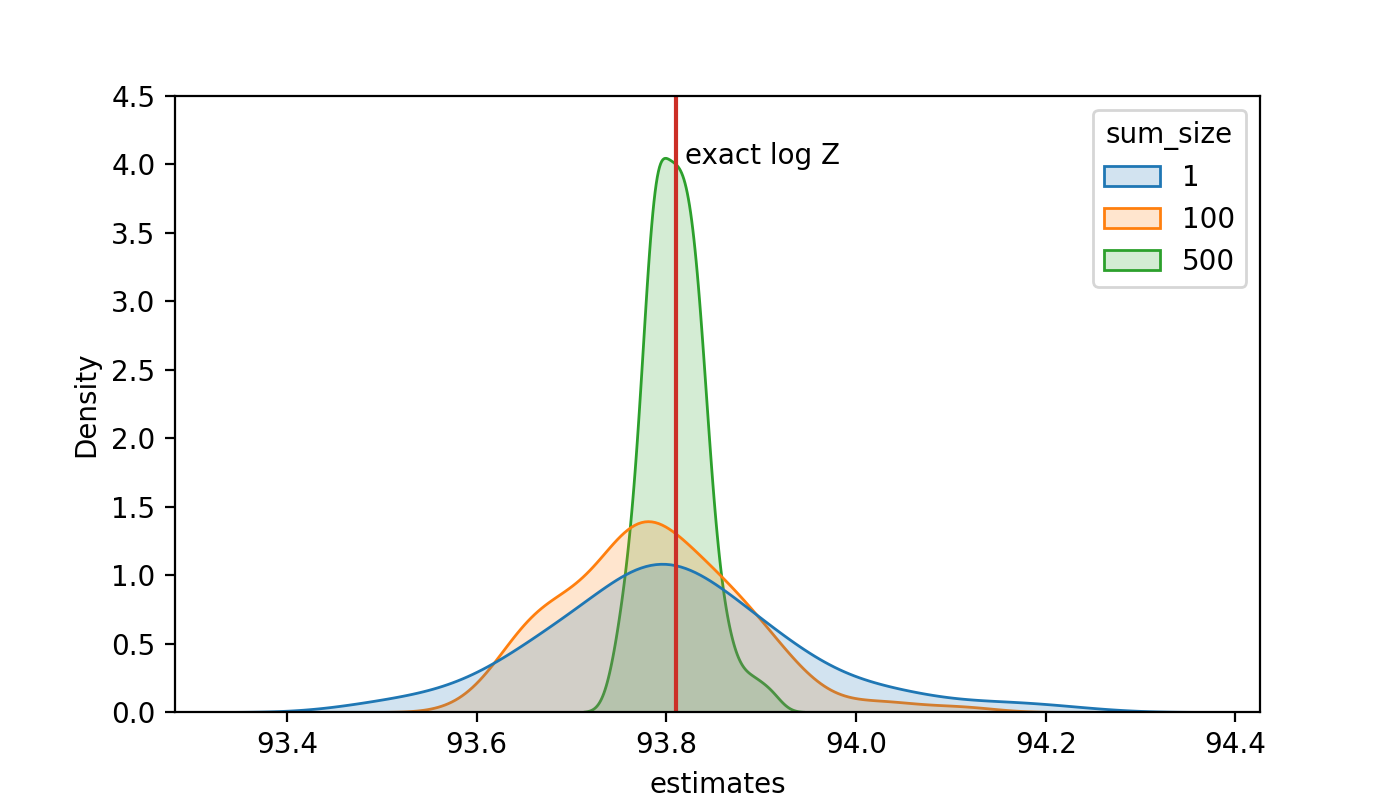

(0.0, 4.5)

In [22]:
# sns.histplot(data=estimates_1, x="values", hue='sum_size', element="step",
#     stat="density", common_norm=False, kde='true'
# )
sns.kdeplot(data=estimates, x="estimates", hue='sum_size', fill=True, alpha=.2)
ymax = 4.5
plt.vlines(log_Z[0], ymin=0, ymax=ymax, color='#CC2F27')
plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
fig.set_size_inches(7, 4)
axes = plt.gca()
axes.set_ylim([0,ymax])

## Variance w.r.t. proposal

In [15]:
estimates_1_softmax, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias)
estimates_100_softmax, est_mean = simulate(state_matrix, emission, lens, 500, transition_bias)
estimates_1_uniform, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 'uniform')
estimates_100_uniform, est_mean = simulate(state_matrix, emission, lens, 500, transition_bias, 'uniform')

  0%|          | 0/100 [00:00<?, ?it/s]

log Z large scale etimate, mean: tensor([93.8030, 93.8151]) std: tensor(0.1404)
approximate time 0.01 s


  9%|▉         | 9/100 [00:00<00:01, 86.36it/s]

log Z large scale etimate, mean: tensor([93.8175, 93.8192]) std: tensor(0.0422)
approximate time 1.44 s


  0%|          | 0/100 [00:00<?, ?it/s]

log Z large scale etimate, mean: tensor([93.8406, 93.8256]) std: tensor(0.1597)
approximate time 0.01 s


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

log Z large scale etimate, mean: tensor([93.8155, 93.8148]) std: tensor(0.0370)
approximate time 1.46 s


<IPython.core.display.Javascript object>


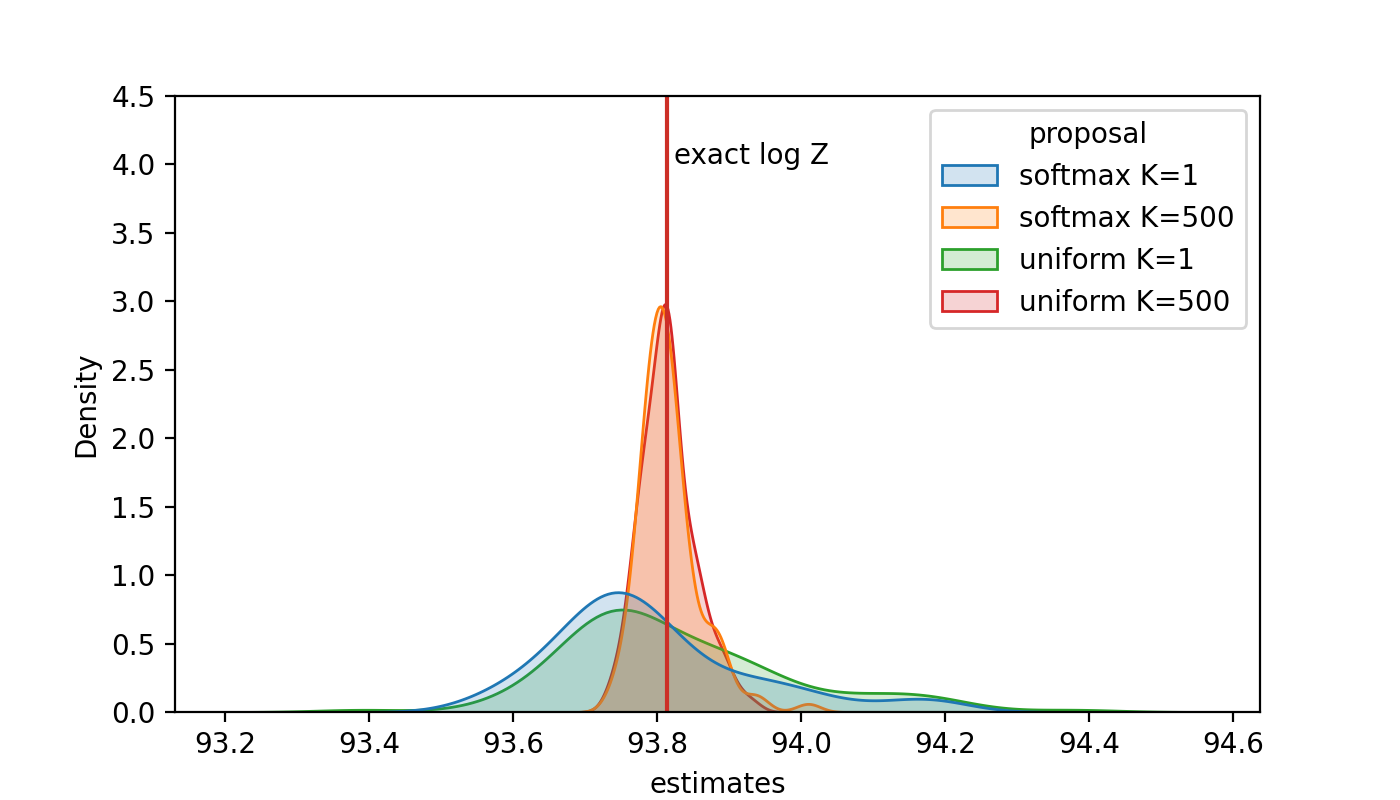

(0.0, 4.5)

In [16]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1_softmax[0]) + list(estimates_100_softmax[0])
                           + list(estimates_1_uniform[0]) + list(estimates_100_uniform[0])), 
     'proposal': np.array(['softmax K=1'] * 100 + ['softmax K=500'] * 100 
                          + ['uniform K=1'] * 100 + ['uniform K=500'] * 100)}
    )
sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
ymax = 4.5
plt.vlines(log_Z[0], ymin=0, ymax=ymax, color='#CC2F27')
plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
fig.set_size_inches(7, 4)
axes = plt.gca()
axes.set_ylim([0,ymax])

<IPython.core.display.Javascript object>


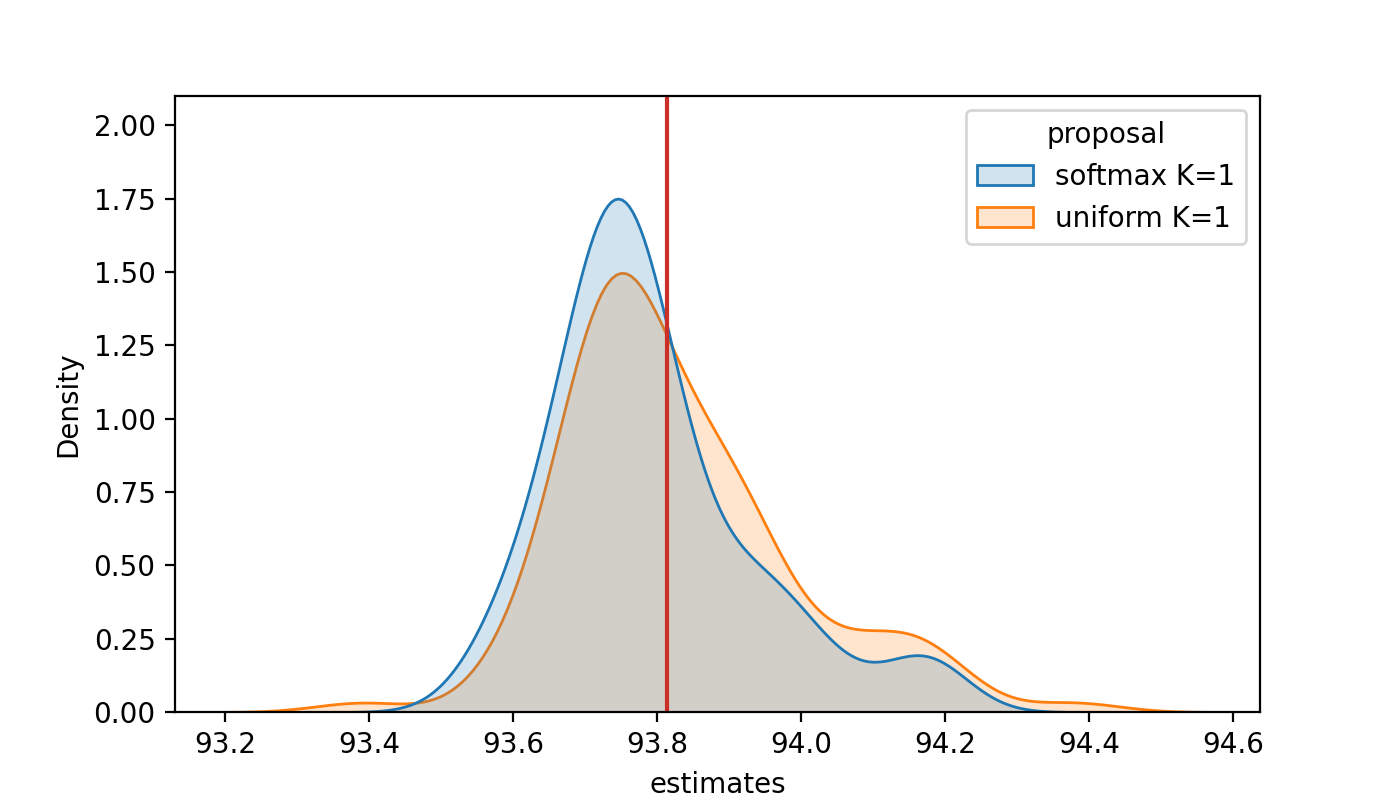

(0.0, 2.1)

In [18]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1_softmax[0]) 
                           + list(estimates_1_uniform[0])), 
     'proposal': np.array(['softmax K=1'] * 100 
                          + ['uniform K=1'] * 100 )}
    )
sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
ymax = 2.1
plt.vlines(log_Z[0], ymin=0, ymax=ymax, color='#CC2F27')
plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
fig.set_size_inches(7, 4)
axes = plt.gca()
axes.set_ylim([0,ymax])

<IPython.core.display.Javascript object>


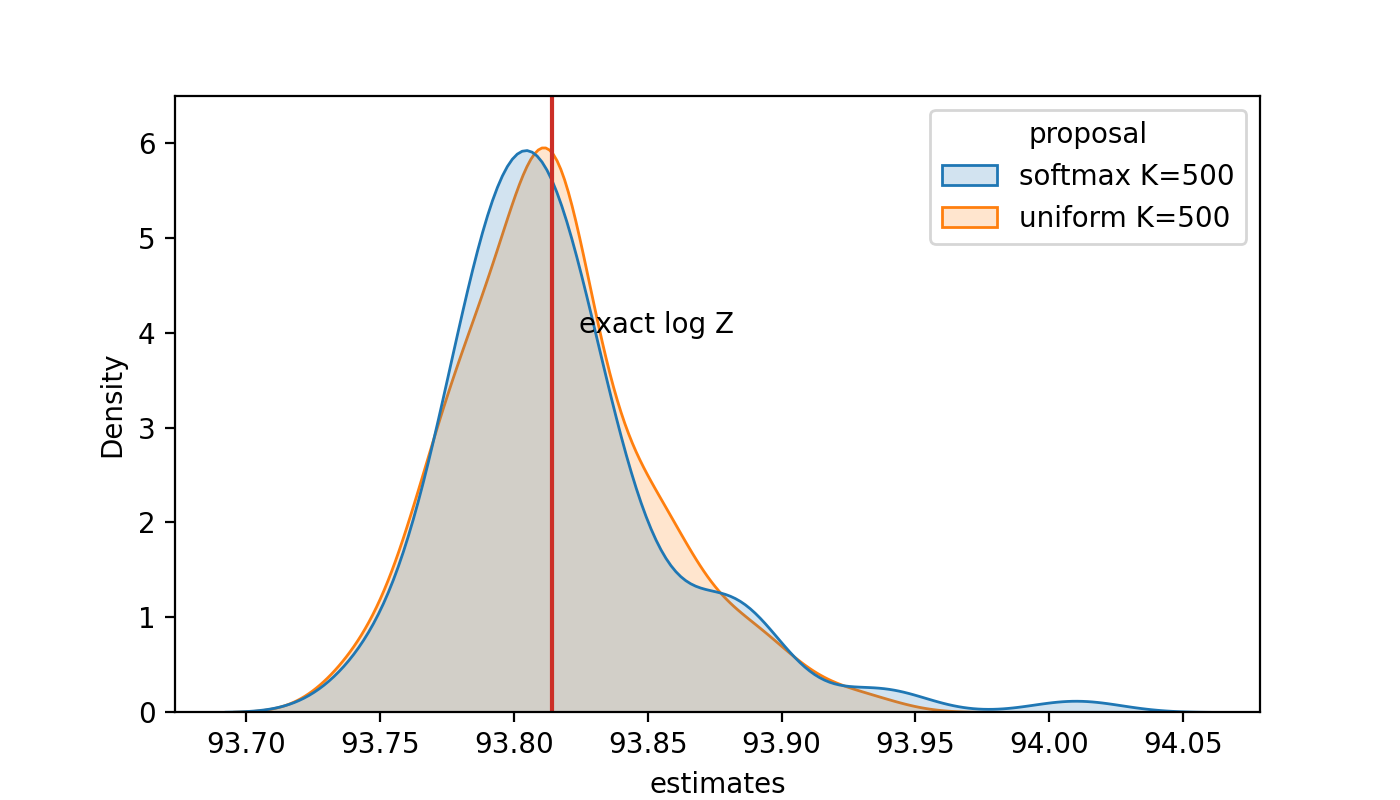

(0.0, 6.5)

In [21]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_100_softmax[0])
                           + list(estimates_100_uniform[0])), 
     'proposal': np.array( ['softmax K=500'] * 100 
                          + ['uniform K=500'] * 100)}
    )
sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
ymax = 6.5
plt.vlines(log_Z[0], ymin=0, ymax=ymax, color='#CC2F27')
plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
fig.set_size_inches(7, 4)
axes = plt.gca()
axes.set_ylim([0,ymax])

## Source of Bias: Large transition factors

When there exist certain transition factors much larger than emission scale, then estimate can be very biased

In [57]:
## Simulate CRFs
transition_scale = 0.01
# transition_scale = 0.475# quite sensitive to this parameter
emission_scale = 0.01
transition_bias = -3
emission_bias = -3
state_size = 762
num_state= 1000
max_len = 100
K_large_state = 2
K_sparse_factor = 4.832 # quite sensitive to this parameter

state_matrix = torch.normal(
  size=[num_state, state_size], mean=0.0, std=transition_scale)
state_matrix[:K_large_state] += 0.6

transition = torch.matmul(
  state_matrix, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + transition_bias

emission_weight = torch.normal(
  size=[2, max_len, state_size], mean=0.0, std=emission_scale)

emission = torch.matmul(
  emission_weight, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + emission_bias
lens = torch.tensor([max_len, max_len])

print('transition gap:', transition.max() - transition.mean())
print('abs transition mean:', transition.abs().mean())
print('emission gap:', emission.max() - emission.mean())
print('abs emission mean:', emission.abs().mean())

_, log_Z = crf.forward_sum(transition, emission, lens)
print('log Z exact:', log_Z)

estimates_1_softmax, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias)
print(est_mean)
estimates_1_uniform, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 'uniform')
print(est_mean)
estimates_trans_prod, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 
                                            transition_proposal='prod')
print(est_mean)
estimates_trans_abs_sum, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 
                                            transition_proposal='abs_sum')
print(est_mean)


transition gap: tensor(9.9463)
abs transition mean: tensor(3.0000)
emission gap: tensor(0.0145)
abs emission mean: tensor(3.)


  7%|▋         | 7/100 [00:00<00:01, 65.45it/s]

log Z exact: tensor([456.9158, 456.8108])


  8%|▊         | 8/100 [00:00<00:01, 75.45it/s]

log Z large scale etimate, mean: tensor([119.0587, 104.1899]) std: tensor(2.4569)
approximate time 0.01 s
tensor([119.0587, 104.1899])


  6%|▌         | 6/100 [00:00<00:01, 53.58it/s]

log Z large scale etimate, mean: tensor([120.9752, 110.3434]) std: tensor(2.6541)
approximate time 0.01 s
tensor([120.9752, 110.3434])


  9%|▉         | 9/100 [00:00<00:01, 81.46it/s]

log Z large scale etimate, mean: tensor([392.2100, 396.1245]) std: tensor(2.1199)
approximate time 0.02 s
tensor([392.2100, 396.1245])


100%|██████████| 100/100 [00:01<00:00, 84.14it/s]

log Z large scale etimate, mean: tensor([446.4746, 442.0478]) std: tensor(6.5369)
approximate time 0.01 s
tensor([446.4746, 442.0478])


<IPython.core.display.Javascript object>


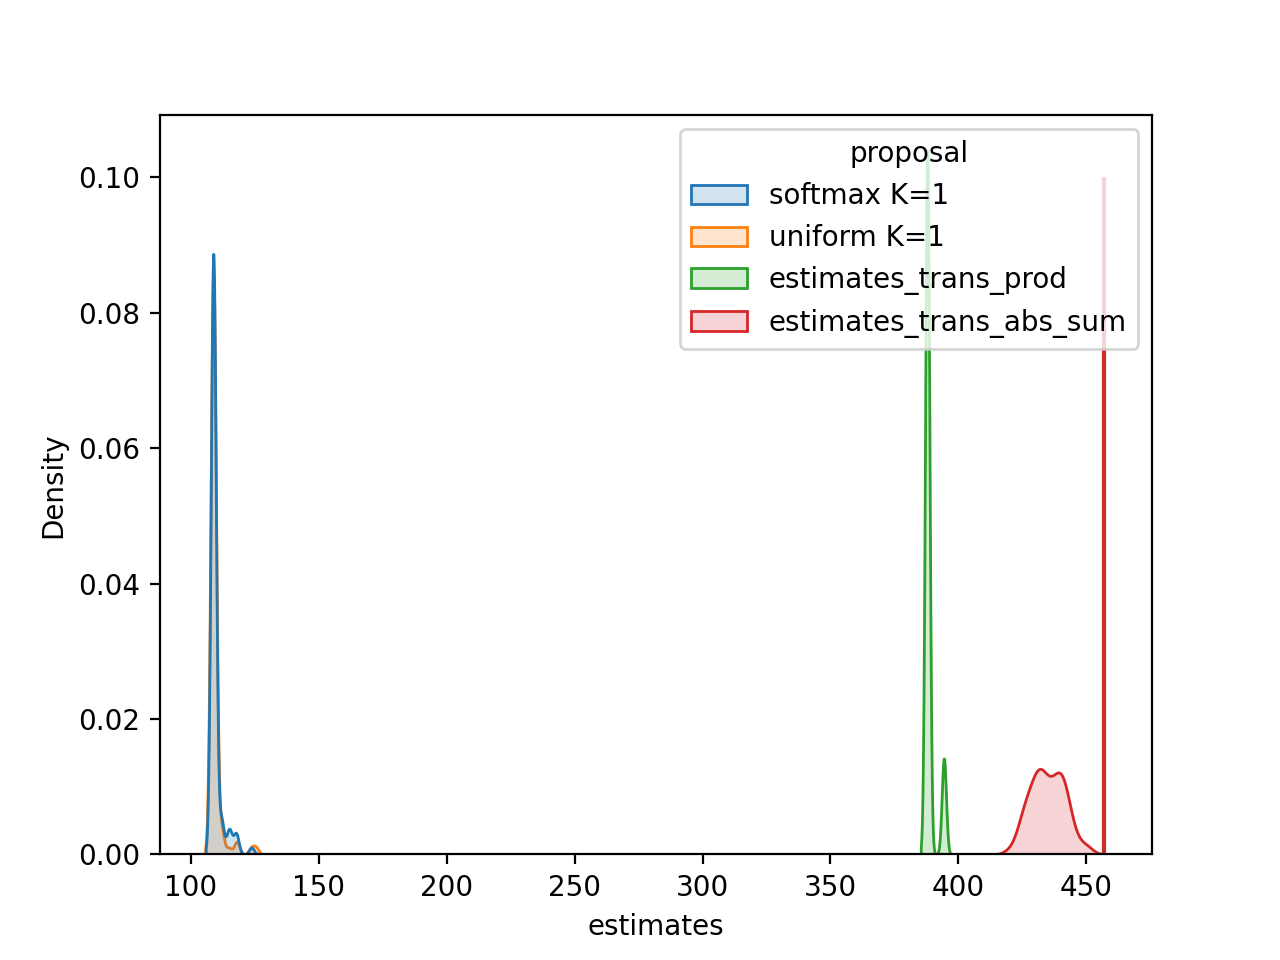

In [59]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1_softmax[0])
                           + list(estimates_1_uniform[0]) 
                           + list(estimates_trans_prod[0])
                           + list(estimates_trans_abs_sum[0])
                          ), 
     'proposal': np.array( ['softmax K=1'] * 100 
                          + ['uniform K=1'] * 100 
                          + ['estimates_trans_prod'] * 100
                          + ['estimates_trans_abs_sum'] * 100
                         )}
    )
sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
# ymax = 6.5
plt.vlines(log_Z[0], ymin=0, ymax=0.1, color='#CC2F27')
# plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
# fig.set_size_inches(7, 4)
axes = plt.gca()
# axes.set_ylim([0,ymax])

Note that in this case, the use of the transition matrix for the proposal helps with the bias

## Source of Bias: scale of the transition much larger than emission

In [60]:
## Simulate CRFs
# transition_scale = 0.01
transition_scale = 0.475# quite sensitive to this parameter
emission_scale = 0.01
transition_bias = -3
emission_bias = -3
state_size = 762
num_state= 1000
max_len = 100
K_large_state = 2
K_sparse_factor = 4.832 # quite sensitive to this parameter

state_matrix = torch.normal(
  size=[num_state, state_size], mean=0.0, std=transition_scale)
# state_matrix[:K_large_state] += 0.6

transition = torch.matmul(
  state_matrix, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + transition_bias

emission_weight = torch.normal(
  size=[2, max_len, state_size], mean=0.0, std=emission_scale)

emission = torch.matmul(
  emission_weight, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + emission_bias
lens = torch.tensor([max_len, max_len])

print('transition gap:', transition.max() - transition.mean())
print('abs transition mean:', transition.abs().mean())
print('emission gap:', emission.max() - emission.mean())
print('abs emission mean:', emission.abs().mean())

_, log_Z = crf.forward_sum(transition, emission, lens)
print('log Z exact:', log_Z)

estimates_1_softmax, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias)
print(est_mean)
estimates_1_uniform, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 'uniform')
print(est_mean)
estimates_trans_prod, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 
                                            transition_proposal='prod')
print(est_mean)
estimates_trans_abs_sum, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 
                                            transition_proposal='abs_sum')
print(est_mean)


transition gap: tensor(7.2796)
abs transition mean: tensor(3.0001)
emission gap: tensor(0.0206)
abs emission mean: tensor(3.0000)


  7%|▋         | 7/100 [00:00<00:01, 65.66it/s]

log Z exact: tensor([140.9256, 140.9282])


  8%|▊         | 8/100 [00:00<00:01, 77.54it/s]

log Z large scale etimate, mean: tensor([100.4565, 100.3364]) std: tensor(2.7675)
approximate time 0.01 s
tensor([100.4565, 100.3364])


  4%|▍         | 4/100 [00:00<00:02, 37.59it/s]

log Z large scale etimate, mean: tensor([101.0861,  99.0147]) std: tensor(2.8406)
approximate time 0.01 s
tensor([101.0861,  99.0147])


  8%|▊         | 8/100 [00:00<00:01, 75.12it/s]

log Z large scale etimate, mean: tensor([102.7174, 101.1291]) std: tensor(3.6983)
approximate time 0.02 s
tensor([102.7174, 101.1291])


100%|██████████| 100/100 [00:01<00:00, 68.52it/s]

log Z large scale etimate, mean: tensor([107.5229, 107.1115]) std: tensor(1.8008)
approximate time 0.01 s
tensor([107.5229, 107.1115])


<IPython.core.display.Javascript object>


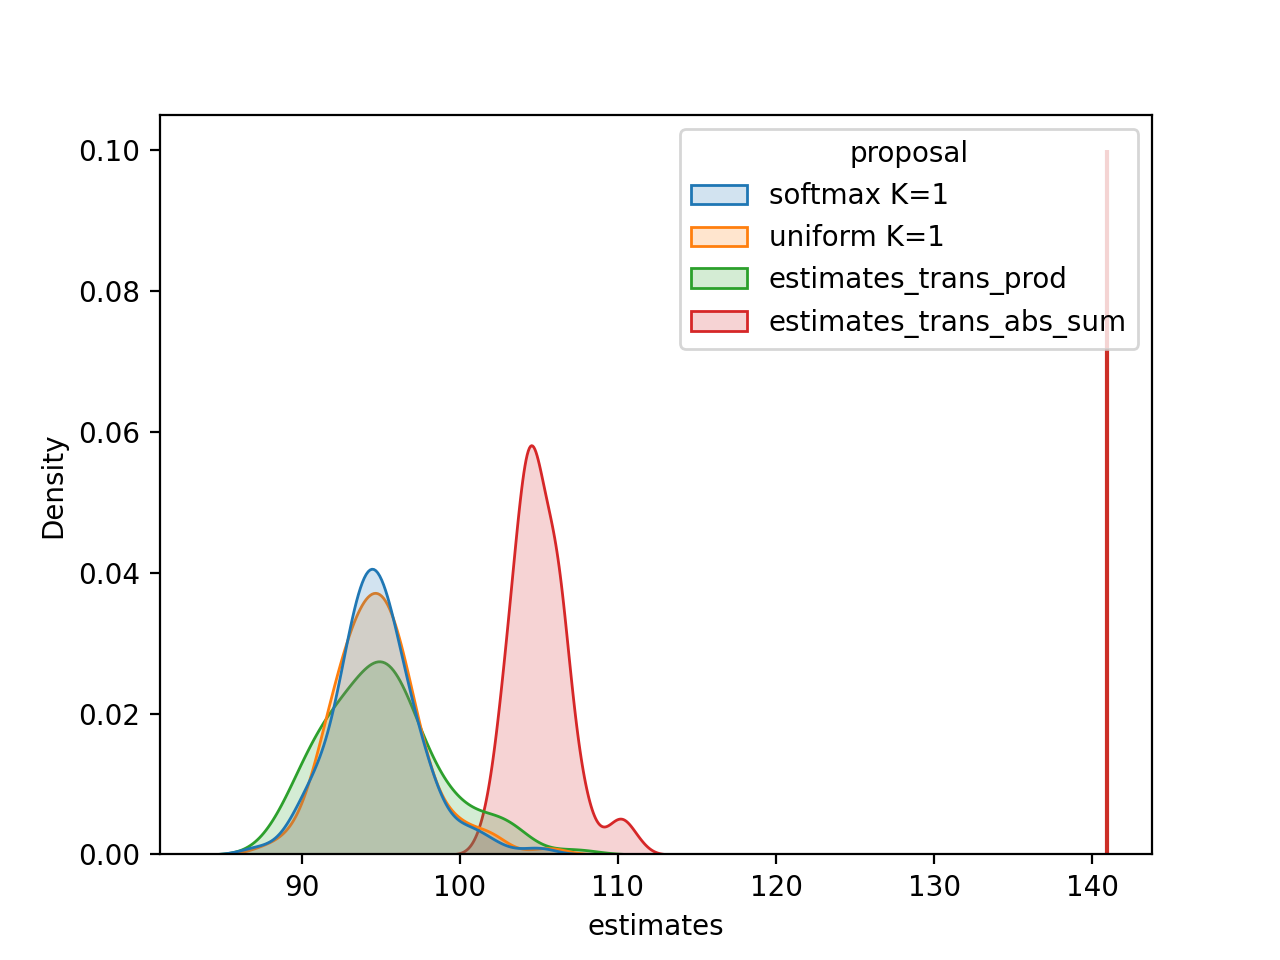

In [61]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1_softmax[0])
                           + list(estimates_1_uniform[0]) 
                           + list(estimates_trans_prod[0])
                           + list(estimates_trans_abs_sum[0])
                          ), 
     'proposal': np.array( ['softmax K=1'] * 100 
                          + ['uniform K=1'] * 100 
                          + ['estimates_trans_prod'] * 100
                          + ['estimates_trans_abs_sum'] * 100
                         )}
    )
sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
# ymax = 6.5
plt.vlines(log_Z[0], ymin=0, ymax=0.1, color='#CC2F27')
# plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
# fig.set_size_inches(7, 4)
axes = plt.gca()
# axes.set_ylim([0,ymax])

## Source of Bias: large emission factors 

In this case softmax is strictly better than uniform

In [13]:
## Simulate CRFs
transition_scale = 0.1
emission_scale = 0.01
transition_bias = -3
emission_bias = -3
state_size = 762
num_state= 1000
max_len = 100
K_large_state = 5

state_matrix = torch.normal(
  size=[num_state, state_size], mean=0.0, std=transition_scale)
transition = torch.matmul(
  state_matrix, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + transition_bias

emission_weight = torch.normal(
  size=[2, max_len, state_size], mean=0.0, std=emission_scale)

emission = torch.matmul(
  emission_weight, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + emission_bias
emission[:, :, :K_large_state] += 2

lens = torch.tensor([max_len, max_len])

print('transition gap:', transition.max() - transition.mean())
print('abs transition mean:', transition.abs().mean())
print('emission gap:', emission.max() - emission.mean())
print('abs emission mean:', emission.abs().mean())

## test sum
_, log_Z = crf.forward_sum(transition, emission, lens)
print('log Z exact:', log_Z)

# _, log_Z_ = crf.forward_sum(0 * transition, emission, lens)
# print('if change to 0 transition, then log Z:', log_Z_)

# _, log_Z_ = crf.forward_sum(transition, 0 * emission, lens)
# print('if change to 0 emission, then log Z:', log_Z_)

# _, log_Z_ = crf.forward_sum(0 * transition, 0 * emission, lens)
# print('if change to all 0, then log Z:', log_Z_)

log_Z_est = crf.approximate_forward(
  state_matrix, emission, lens, num_state - 1, None, transition_bias)
print('log Z full estimate:', log_Z_est)

transition gap: tensor(0.3216)
abs transition mean: tensor(2.9997)
emission gap: tensor(1.9927)
abs emission mean: tensor(2.9900)
log Z exact: tensor([96.9635, 96.9638])
log Z full estimate: tensor([96.9635, 96.9638])


In [14]:
estimates_1_softmax, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias)
print(est_mean)
estimates_1_uniform, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias, 'uniform')
print(est_mean)

  9%|▉         | 9/100 [00:00<00:01, 80.27it/s]

log Z large scale etimate, mean: tensor([96.9907, 96.9453]) std: tensor(0.1547)
approximate time 0.01 s
tensor([96.9907, 96.9453])


100%|██████████| 100/100 [00:01<00:00, 84.24it/s]

log Z large scale etimate, mean: tensor([96.8239, 97.0428]) std: tensor(1.3578)
approximate time 0.01 s
tensor([96.8239, 97.0428])


<IPython.core.display.Javascript object>


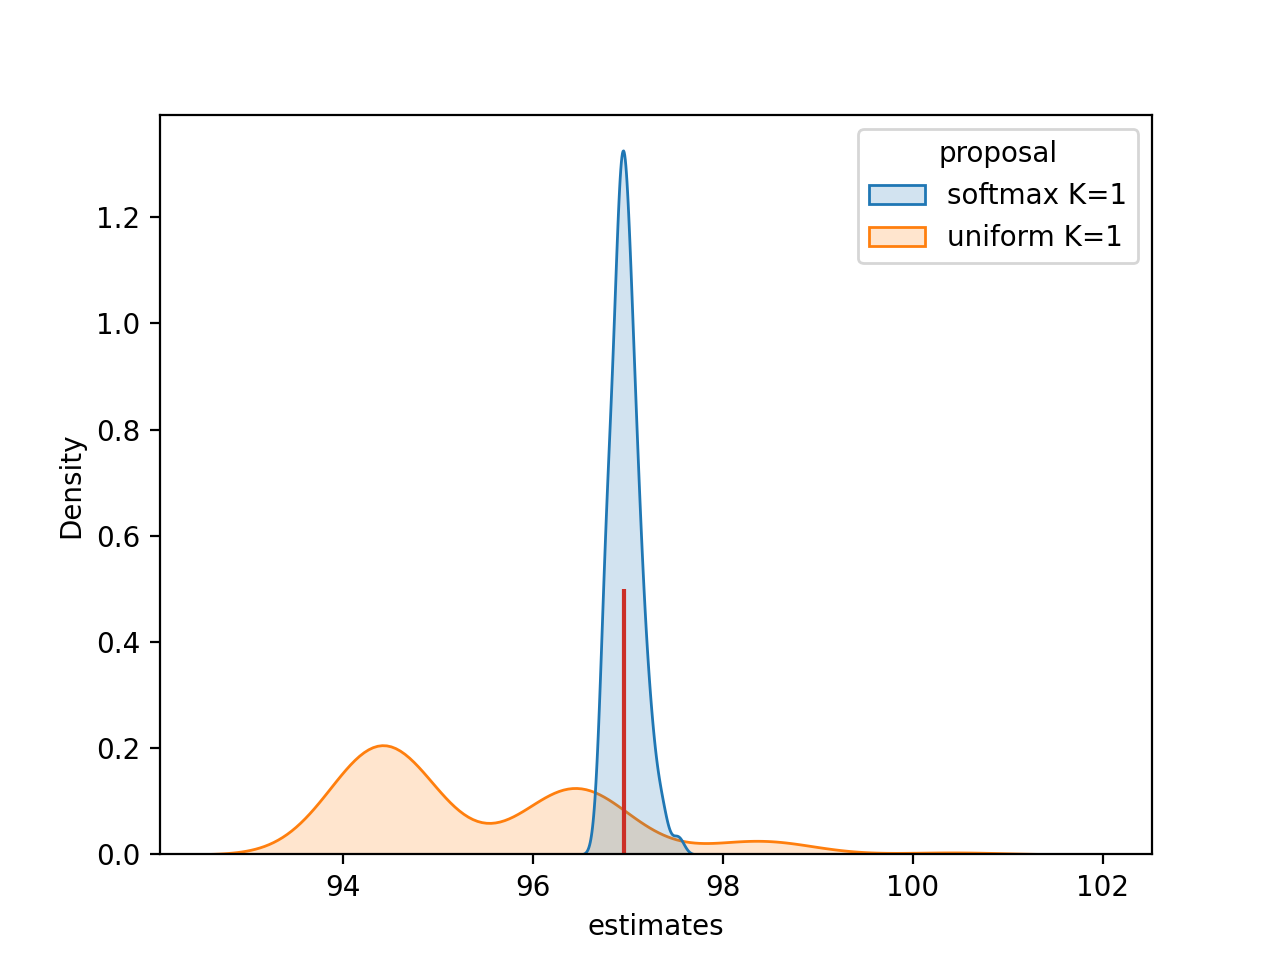

In [15]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1_softmax[0])
                           + list(estimates_1_uniform[0])
                        ), 
     'proposal': np.array( ['softmax K=1'] * 100 
                          + ['uniform K=1'] * 100
                         )}
    )
sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
# ymax = 6.5
plt.vlines(log_Z[0], ymin=0, ymax=0.5, color='#CC2F27')
# plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
# fig.set_size_inches(7, 4)
axes = plt.gca()
# axes.set_ylim([0,ymax])

## Comparison to top K sum

<IPython.core.display.Javascript object>


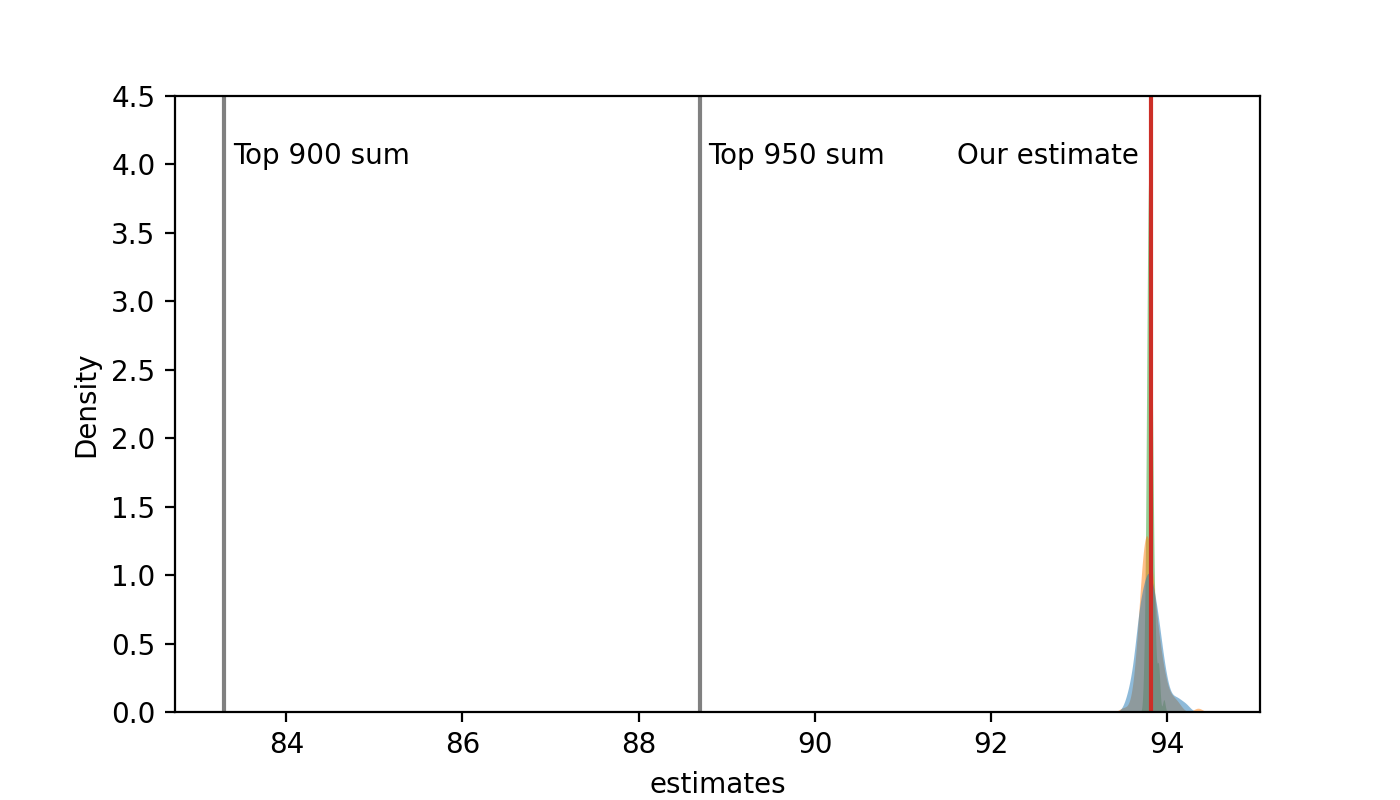

(0.0, 4.5)

In [127]:
p1 = sns.kdeplot(data=estimates, x="estimates", hue='sum_size', fill=True, alpha=.5, linewidth=0, legend=False)
ymax = 4.5
p2 = plt.vlines([log_Z_topk_900, log_Z_topk_950], ymin=0, ymax=ymax, color='gray', label='topK')
plt.text(log_Z_topk_900+0.1, 4, 'Top 900 sum')
plt.text(log_Z_topk_950+0.1, 4, 'Top 950 sum')
p3 = plt.vlines([log_Z[0].item()], ymin=0, ymax=ymax, color='#007aff', label='exact', linewidth=0.2)
p3 = plt.vlines([est_mean[0]], ymin=0, ymax=ymax, color='#CC2F27', label='ours')
plt.text(est_mean[0]-2.2, 4, 'Our estimate')
fig = plt.gcf()
fig.set_size_inches(7, 4)
axes = plt.gca()
axes.set_ylim([0,ymax])
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))

## Test exact computation

In [154]:
## Simulate CRFs
transition_scale = 0.1
emission_scale = 0.01
# transition_bias = -1
# emission_bias = -1
transition_bias = -3.5
emission_bias = -3.5
state_size = 762
num_state= 1000
max_len = 10

state_matrix = torch.normal(
  size=[num_state, state_size], mean=0.0, std=transition_scale)
transition = torch.matmul(
  state_matrix, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + transition_bias
emission_weight = torch.normal(
  size=[2, max_len, state_size], mean=0.0, std=emission_scale)
emission = torch.matmul(
  emission_weight, state_matrix.transpose(1, 0)) / np.sqrt(state_size)\
  + emission_bias
lens = torch.tensor([max_len, max_len])

print('transition gap:', transition.max() - transition.mean())
print('abs transition mean:', transition.abs().mean())
print('emission gap:', emission.max() - emission.mean())
print('abs emission mean:', emission.abs().mean())

transition gap: tensor(0.3300)
abs transition mean: tensor(3.4998)
emission gap: tensor(0.0039)
abs emission mean: tensor(3.5000)


In [155]:
_, log_Z = crf.forward_sum(transition, emission, lens)
print('log Z exact:', log_Z)

_, log_Z_ = crf.forward_sum(0 * transition, emission, lens)
print('if change to 0 transition, then log Z:', log_Z_)

_, log_Z_ = crf.forward_sum(transition, 0 * emission, lens)
print('if change to 0 emission, then log Z:', log_Z_)

_, log_Z_ = crf.forward_sum(0 * transition, 0 * emission, lens)
print('if change to all 0, then log Z:', log_Z_)

log_Z_est = crf.approximate_forward(
  state_matrix, emission, lens, num_state - 1, None, transition_bias)
print('log Z full estimate:', log_Z_est)

log Z exact: tensor([2.5805, 2.5806])
if change to 0 transition, then log Z: tensor([34.0774, 34.0776])
if change to 0 emission, then log Z: tensor([37.5806, 37.5806])
if change to all 0, then log Z: tensor([69.0776, 69.0776])
log Z full estimate: tensor([2.5805, 2.5806])


In [156]:
estimates_1, est_mean = simulate(state_matrix, emission, lens, 1, transition_bias)
estimates_100, est_mean = simulate(state_matrix, emission, lens, 100, transition_bias)
estimates_500, est_mean = simulate(state_matrix, emission, lens, 500, transition_bias)


 11%|█         | 11/100 [00:00<00:00, 108.74it/s]

log Z large scale etimate, mean: tensor([2.5820, 2.5830]) std: tensor(0.0537)
approximate time 0.00 s


  1%|          | 1/100 [00:00<00:15,  6.20it/s]

log Z large scale etimate, mean: tensor([2.5783, 2.5813]) std: tensor(0.0328)
approximate time 0.01 s


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]

log Z large scale etimate, mean: tensor([2.5815, 2.5808]) std: tensor(0.0071)
approximate time 0.11 s


<IPython.core.display.Javascript object>


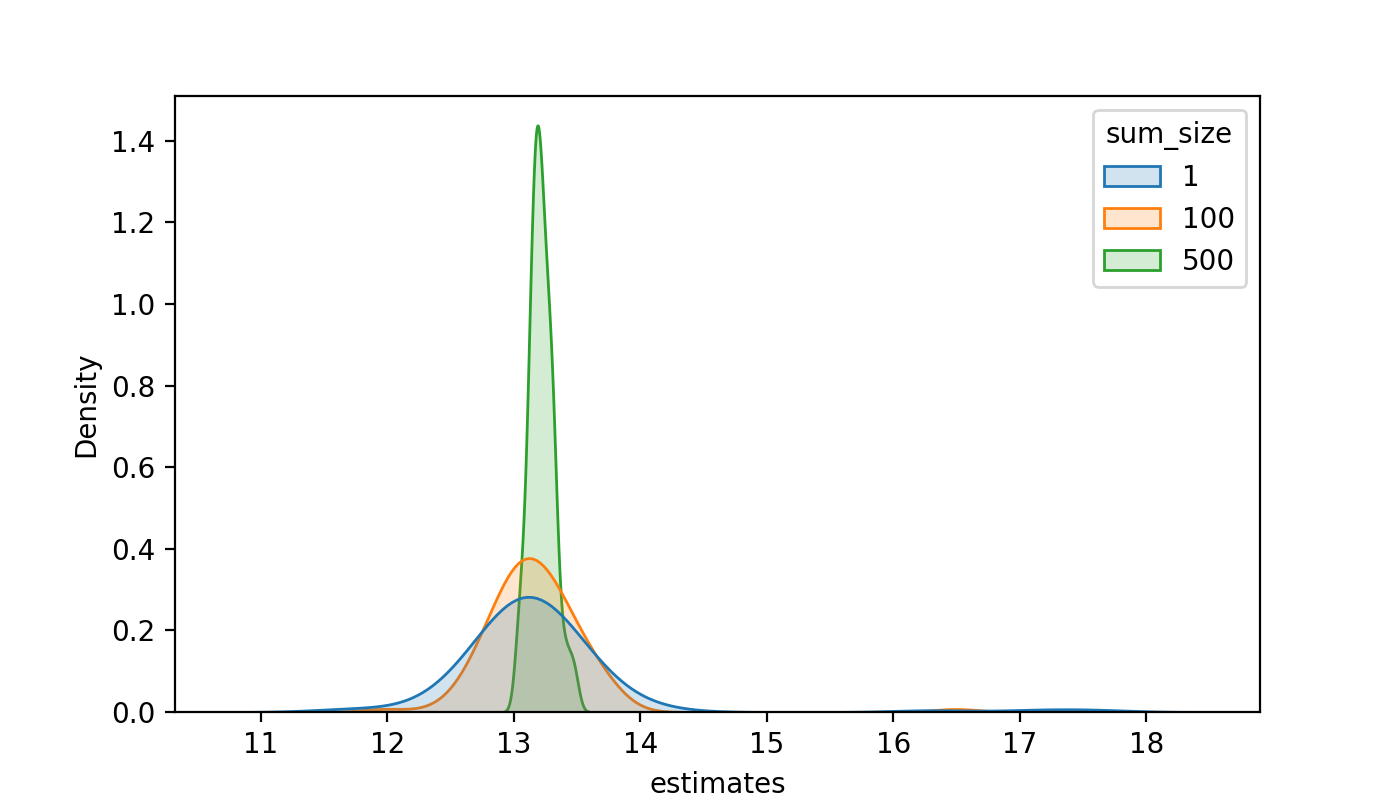

In [157]:
estimates = pd.DataFrame(
    {
     'estimates': np.array(list(estimates_1[0].exp()) + list(estimates_100[0].exp()) + list(estimates_500[0].exp())), 
     'sum_size': np.array(['1'] * 100 + ['100'] * 100 + ['500'] * 100)}
    )
sns.kdeplot(data=estimates, x="estimates", hue='sum_size', fill=True, alpha=.2)
ymax = 1200
# plt.vlines(log_Z[0].exp(), ymin=0, ymax=ymax, color='#CC2F27')
# plt.text(log_Z[0]+0.01, 4, 'exact log Z')
fig = plt.gcf()
fig.set_size_inches(7, 4)
axes = plt.gca()
# axes.set_ylim([0,ymax])

# Simple summation test

In [451]:
N = 10000
k = 200
x = np.random.uniform(0, 10, N)

In [453]:
x.sort()

In [454]:
x.sum()

50235.86195202636

In [589]:
estimates = []
for _ in range(1000):
    estimates.append(8000 / k * np.random.choice(x[:-2000], size=k).sum() + x[-2000:].sum())
print(np.mean(estimates))
print(np.std(estimates))

50311.066555580204
1321.304109210851


In [572]:
estimates = []
for _ in range(1000):
    estimates.append(10000 / k * np.random.choice(x, size=k).sum())
print(np.mean(estimates))
print(np.std(estimates))

50193.53422870552
2038.6411509574114
